In [472]:
import numpy as np
from scipy import interpolate
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

import glob
import astropy.io.fits as pf
from astropy import constants as const
import astropy.units as u
from astropy.time import Time
from astropy.timeseries import LombScargle

# **Voorbereiding**

In [473]:
sternaam = 'BD-11_162'

# Maak een lijst van alle spectra. Data is in FITS format
datalist = glob.glob("%s/*.fits" %sternaam)
datalist.sort()


# Inlezen van de spectrale lijnen. De goflengte is in rust en in lucht (niet vacuum)
inputfile = "%s/LijnLijst.txt" %sternaam
lines,weights = np.loadtxt(inputfile,usecols=(0,1),unpack=True)

In [474]:
# bereken de golflengte uit de data
def golflengte_grid(spec, header):

    # Lees meta-data
    ref_pix = int(header['CRPIX1'])-1   # index van de referentiepixel
    ref_val = float(header['CRVAL1'])   # ln(golflengte) van de referentiepixel
    ref_del = float(header['CDELT1'])   # breedte van de pixel in eenheid van CRVAL1
    JD = header['BJD']  # datum van de waarneming in Juliaanse dagen
    unitx = header['CTYPE1']

    numberpoints = spec.shape[0]

    # Maak een golflengtegrid aan
    wavelengthbegin = ref_val - ref_pix*ref_del
    wavelengthend = wavelengthbegin + (numberpoints-1)*ref_del
    wavelengths = np.linspace(wavelengthbegin,wavelengthend,numberpoints)
    wavelengths = np.exp(wavelengths)

    return wavelengths, JD, unitx

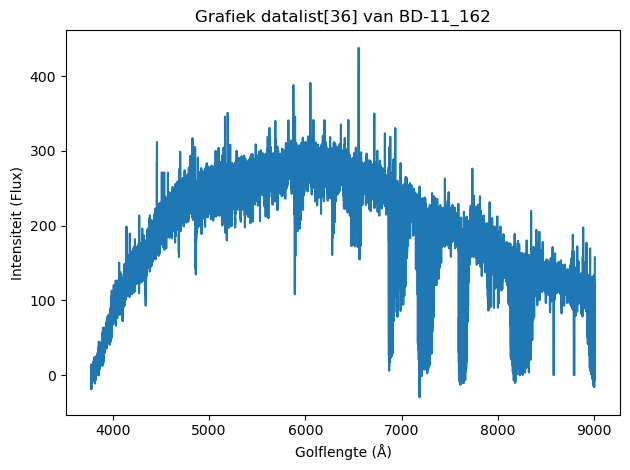

In [475]:
# bekijk de data voor datalist[36]
spec = pf.getdata(datalist[36])
header = pf.getheader(datalist[36])

wavelengths, JD, unitx = golflengte_grid(spec, header)
wavelengths = wavelengths
spec = spec

# grafiek van datalist[2]
fig, ax = plt.subplots()
ax.plot(wavelengths, spec)
plt.title("Grafiek datalist[36] van BD-11_162")
ax.set_ylabel("Intensiteit (Flux)")
ax.set_xlabel("Golflengte (Å)")
plt.tight_layout()
plt.savefig("datalist36plot.jpg")
plt.show()

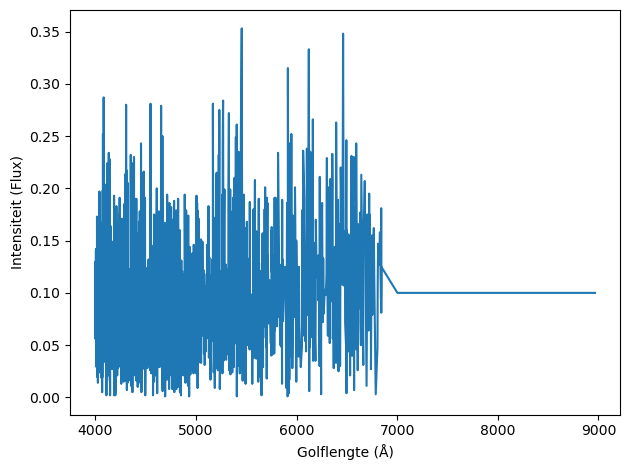

In [476]:
# grafiek van LijnLijst.txt
fig, ax = plt.subplots()
ax.plot(lines, weights)
ax.set_ylabel("Intensiteit (Flux)")
ax.set_xlabel("Golflengte (Å)")
plt.tight_layout()
plt.show()

# **Radiale Snelheid**

In [477]:
# defineer de formules om de radiale snelheid te berekenen
c = const.c
c_kms = c.value * 10**-3

def doppler(v, lambda0):
    return (v*lambda0)/c_kms + lambda0

# probeer verschillende snelheden en neem de kleinst mogelijke error marge op de lambda
def beste_v(wavelength, spec, lines, v_bereik, v_steps):
    # genereer snelheden om te testen
    v_test = np.arange(v_bereik[0], v_bereik[1] + v_steps, v_steps)
    # maak interpolatiefunctie om te snelheden te testen
    interpolate_functie = interpolate.interp1d(wavelength, spec)
    # variabelen voor de fout-kostfunctie
    wavelengthmax, wavelengthmin = wavelength.max(), wavelength.min()
    error_kost = []

    # bereken de fout voor de snelheden
    for v in v_test:
        # bereken de doppler shift
        lambda_shift = doppler(v, lines)
        # filter enkel lijnen binnen de bereik
        binnen_bereik = binnen_bereik = np.logical_and(lambda_shift >= wavelengthmin, lambda_shift <= wavelengthmax)
        lambda_shift = lambda_shift[binnen_bereik]

        # MSE
        if lambda_shift.size > 0:
            flux_observatie = interpolate_functie(lambda_shift)
            fout_mse = ((flux_observatie)**2).mean()
        else:
            fout_mse = np.inf
        error_kost.append(fout_mse)

    # beste snelheid vinden
    error_kost = np.array(error_kost)
    beste_index = np.argmin(error_kost)
    beste_v = v_test[beste_index]
    min_mse = error_kost[beste_index]

    return v_test, beste_v, error_kost

# fomrules om de raidale snelheid te schatten a.d.h.v beste 2de graads fit en ook dus de foutmarge
def radiale_min_fit(x, a, b, c):
    return a*x**2 + b*x + c

def rad(v_t, error_kost, marge): # marge is het aantal punten die we nemen rondom het minimum
    minimum = np.where(error_kost == error_kost.min())
    begin = int((minimum[0] - marge)[0]) # links van het minimum
    einde = int((minimum[0] + marge)[0]) # rechts van het minimum

    popt, pcov = curve_fit(radiale_min_fit, v_t[begin:einde], error_kost[begin:einde])
    onzekerheden = np.sqrt(np.diag(pcov))

    coefficienten = popt
    a, b, c = popt
    nulpunt = -b / (2*a) # berekende minimum door de schatting

    # onzekerheid = sqrt((deltav/deltab * b)**2 + (deltav/deltab * delta a)**2 )
    onzekerheid = np.sqrt((-1/(2*a) * onzekerheden[1])**2 + (b/(2*a**2) * onzekerheden[0])**2)

    return nulpunt, onzekerheid, coefficienten, begin, einde

radiale snelheid vinden van 1 data in de datalist

In [478]:
test = datalist[36]

test_datalist = glob.glob(test)
test_datalist.sort()
test_spec = pf.getdata(test_datalist[0])
test_header = pf.getheader(test_datalist[0])

test_wl, test_JD, test_unitx = golflengte_grid(test_spec, test_header)

In [479]:
v_t, beste_v_t, error_kost_t = beste_v(test_wl, test_spec, lines, (-50, 50), 0.01)

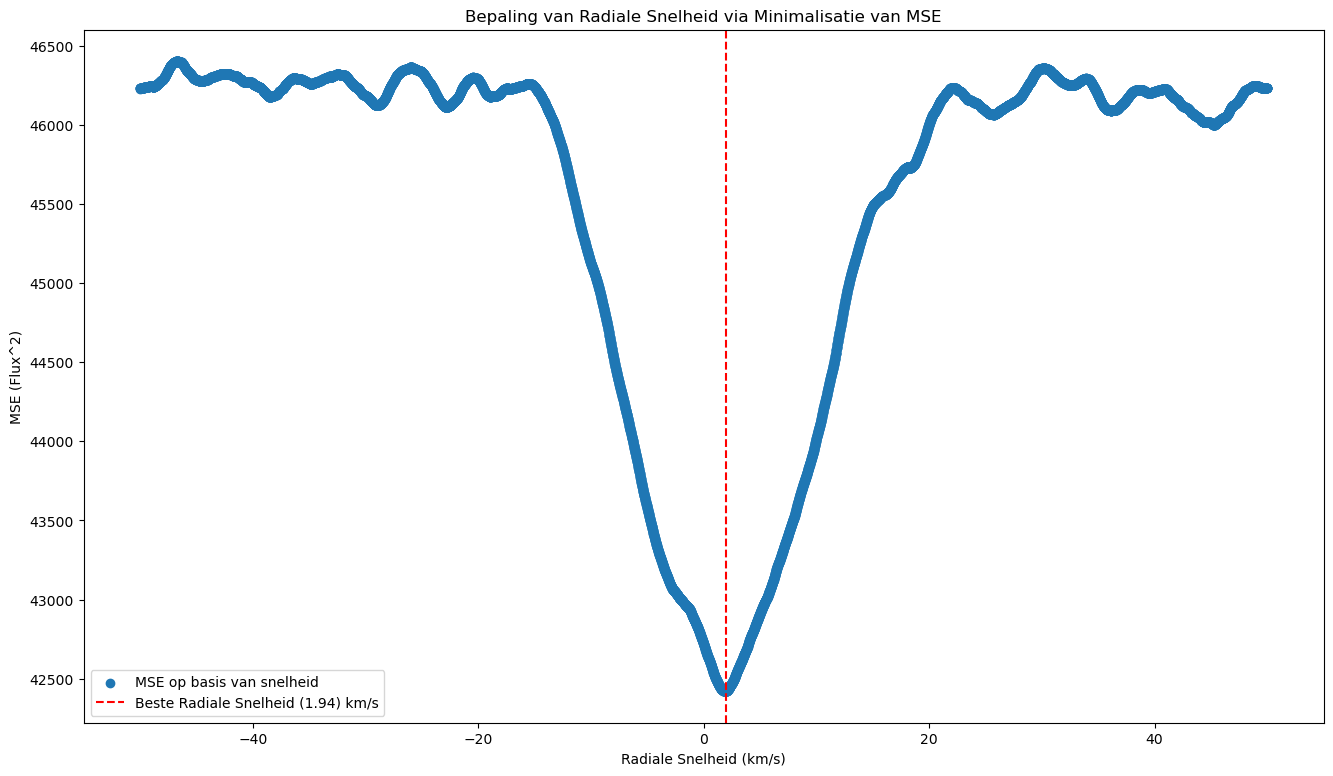

In [480]:
# grafiek van error_kort bepalend van de snelheid
fig, ax = plt.subplots(figsize = (16, 9))
ax.scatter(v_t, error_kost_t, label="MSE op basis van snelheid") # Functie error(v)
plt.axvline(float(beste_v_t), color="red", linestyle="--", label=f"Beste Radiale Snelheid ({beste_v_t:.2f}) km/s")

ax.set_xlabel("Radiale Snelheid (km/s)")
ax.set_ylabel("MSE (Flux^2)")
plt.title("Bepaling van Radiale Snelheid via Minimalisatie van MSE")
plt.legend()
plt.savefig("BeplaingVMSE.jpg")
plt.show()

In [481]:
# bereken de beste fit van de radieale snelheid t.o.v MSE
beste_v_fit, onzekerheden, coefficienten , begin, einde = rad(v_t, error_kost_t, 10)
a, b, c = coefficienten

# maak de curve van de fit
v_t_fit = np.linspace(v_t[begin], v_t[einde], 1000)
MSE_fit = radiale_min_fit(v_t_fit, a, b, c)

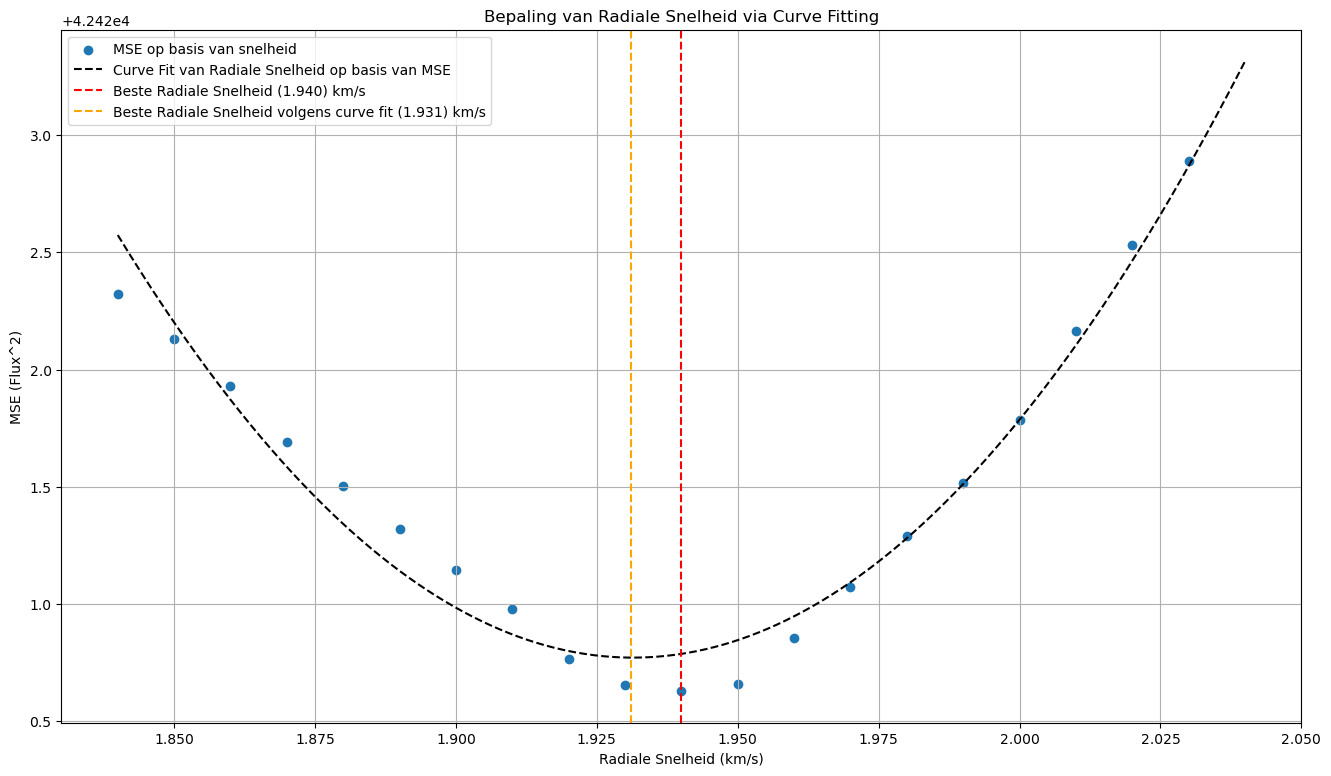

In [482]:
# grafiek van radiale snelheid via MSE en radiale snelheid via curve_fit
fig, ax = plt.subplots(figsize = (16, 9))
ax.scatter(v_t[begin:einde], error_kost_t[begin:einde], label="MSE op basis van snelheid") # Functie error(v)
ax.plot(v_t_fit, MSE_fit, color="black", linestyle="--",
        label=f"Curve Fit van Radiale Snelheid op basis van MSE")
plt.axvline(float(round(beste_v_t, 3)), color="red", linestyle="--", label=f"Beste Radiale Snelheid ({beste_v_t:.3f}) km/s")
plt.axvline(float(round(beste_v_fit, 3)), color="orange", linestyle="--",
            label=f"Beste Radiale Snelheid volgens curve fit ({beste_v_fit:.3f}) km/s")

ax.set_xlabel("Radiale Snelheid (km/s)")
ax.set_ylabel("MSE (Flux^2)")
plt.title("Bepaling van Radiale Snelheid via Curve Fitting")
plt.legend()
plt.grid(True)
plt.savefig("CurveFit_v.jpg")
plt.show()

De onzekerheid door verschillende v te proberen en de beste te vinden is veel kleiner dan de systematische fouten: kalibratie, drift, ruis,...
We concluderen dus, dat de onzekerheid bepaald is door systematische fouten en niet door statistische onzekerheid van de doppler en beste_v 

## **Radiale snelheid voor alle gekregen data van BD-11_162**

In [483]:
# schat het bereik van de radiale snelheden
geschatte_snelheden = []

for data in datalist:
    spec = pf.getdata(data)
    header = pf.getheader(data)

    wavelengths, JD, unitx = golflengte_grid(spec, header)
    v_t, beste_v_t, error_kost = beste_v(wavelengths, spec, lines, (-100, 100), 1)

    geschatte_snelheden.append(beste_v_t)

min_snelheid = min(geschatte_snelheden) - 1
max_snelheid = max(geschatte_snelheden) + 1

In [484]:
# schat het bereik van de radiale snelheden
snelheid = [] # volgens MSE
snelheid_fit = [] # volgens fit
tijd = []
onzekerheid_v = [] # volgens fit

# itereer over alle data
for data in datalist:
    spec = pf.getdata(data)
    header = pf.getheader(data)

    # bereken alle waarden
    wavelengths, JD, unitx = golflengte_grid(spec, header)
    v_t, beste_v_t, error_kost = beste_v(wavelengths, spec, lines, (min_snelheid, max_snelheid), 0.01)
    nulpunt, onzekerheid, coefficienten, begin, einde = rad(v_t, error_kost, 10)

    # zet nodige waarden in lijst
    snelheid.append(beste_v_t)
    snelheid_fit.append(nulpunt)
    onzekerheid_v.append(onzekerheid)
    tijd.append(JD)
    

In [485]:
# conversie van Juliaanse tijd
def jul2norm(tijd):
    
    t = Time(tijd, format="jd", scale='tdb')
    datum = t.to_datetime()
    return datum

In [486]:
datum = jul2norm(tijd)

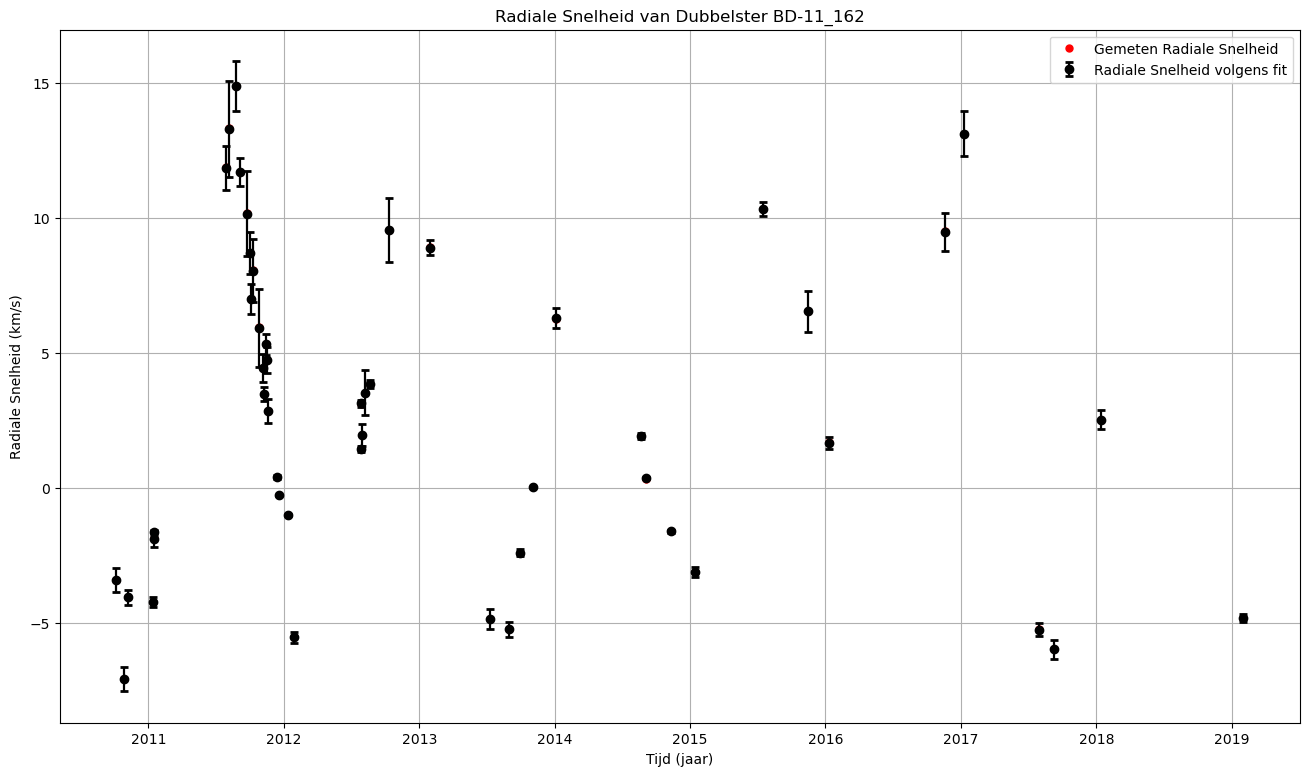

In [487]:
# plot Radiale Snelheid door de tijd heen
fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(datum, snelheid, 'o', color='red', markersize=5, label='Gemeten Radiale Snelheid')
ax.errorbar(
    datum,
    snelheid_fit,
    yerr=onzekerheid_v,
    linestyle='',
    color='black',
    ecolor='black',
    marker="o",
    markersize=6,
    capsize=3,
    capthick=2,
    linewidth=1.6,
    label='Radiale Snelheid volgens fit'
)

ax.set_xlabel("Tijd (jaar)")
ax.set_ylabel("Radiale Snelheid (km/s)")
plt.title(f'Radiale Snelheid van Dubbelster {sternaam}')
plt.grid(True)
plt.legend()
plt.show()

## **Periode, Amplitude en massa**

In [488]:
# model voor fit functie
def radiale_snelheid_fit(tijd, amplitude, t0, b, P):
    # v(t) = A*sin(2pi/P * (t-t0)) + b
    # P = P_dagen
    return amplitude * np.sin((2*np.pi / P) * (tijd - t0)) + b

def fit_gok(tijd, snelheid): # online gevonden, werkt wel
    # PERIODE GOK
    t = np.array(tijd)
    v = np.array(snelheid)
    # test periodes tussen 1 en 1000 dagen
    frequenties = np.linspace(1/1000, 1, 10000)

    power = LombScargle(t, v).power(frequenties)
    # neem beste frequentie (hoogste piek); online gevonden
    beste_freq = frequenties[np.argmax(power)]
    # periode = 1/freq
    P_dagen = 1.0/beste_freq
    # AMPLITUDE, B, T0 GOK
    amplitude = (v.max() - v.min()) / 2
    b = np.median(v)
    t0 = t[np.argmin(v)] # Datum van het minimum

    return (P_dagen, amplitude, b, t0, t, v)

def fit(tijd, snelheid_f):
    # bereken gokken
    P_dagen_gok, amplitude_gok, b_gok, t0_gok, t, v = fit_gok(tijd, snelheid_f)

    # fit calculatie
    popt, pcov = curve_fit(radiale_snelheid_fit, t, v, p0=[amplitude_gok, t0_gok, b_gok, P_dagen_gok])
    onzekerheid = np.sqrt(np.diag(pcov))

    # Bekijk de fit
    amplitude, t0, b, P_fit = popt
    delta_A, delta_t0, delta_b, delta_P_fit = onzekerheid
    
    print(f"Amplitude (A): {amplitude:.2f} +/- {delta_A:.2f} km/s")
    print(f"t0: {t0:.2f} +/- {delta_t0:0.2f} dagen")
    print(f"Systemische Snelheid (b): {b:.2f} +/- {delta_b:.2f} km/s")
    print(f"Periode (dagen): {P_fit:.2f} +/- {delta_P_fit:.2f} dagen")

    # return amplitude, t0, b, P_fit, delta_A, sigma_t0, sigma_b, sigma_P_fit
    return popt, onzekerheid

### **Voor radiale snelheid door MSE**

In [489]:
v_mse = fit(tijd, snelheid)
A = v_mse[0][0]
t0 = v_mse[0][1]
b = v_mse[0][2]
P = v_mse[0][3]

Amplitude (A): 8.68 +/- 0.28 km/s
t0: 2455640.80 +/- 3.36 dagen
Systemische Snelheid (b): 3.22 +/- 0.19 km/s
Periode (dagen): 498.12 +/- 1.78 dagen


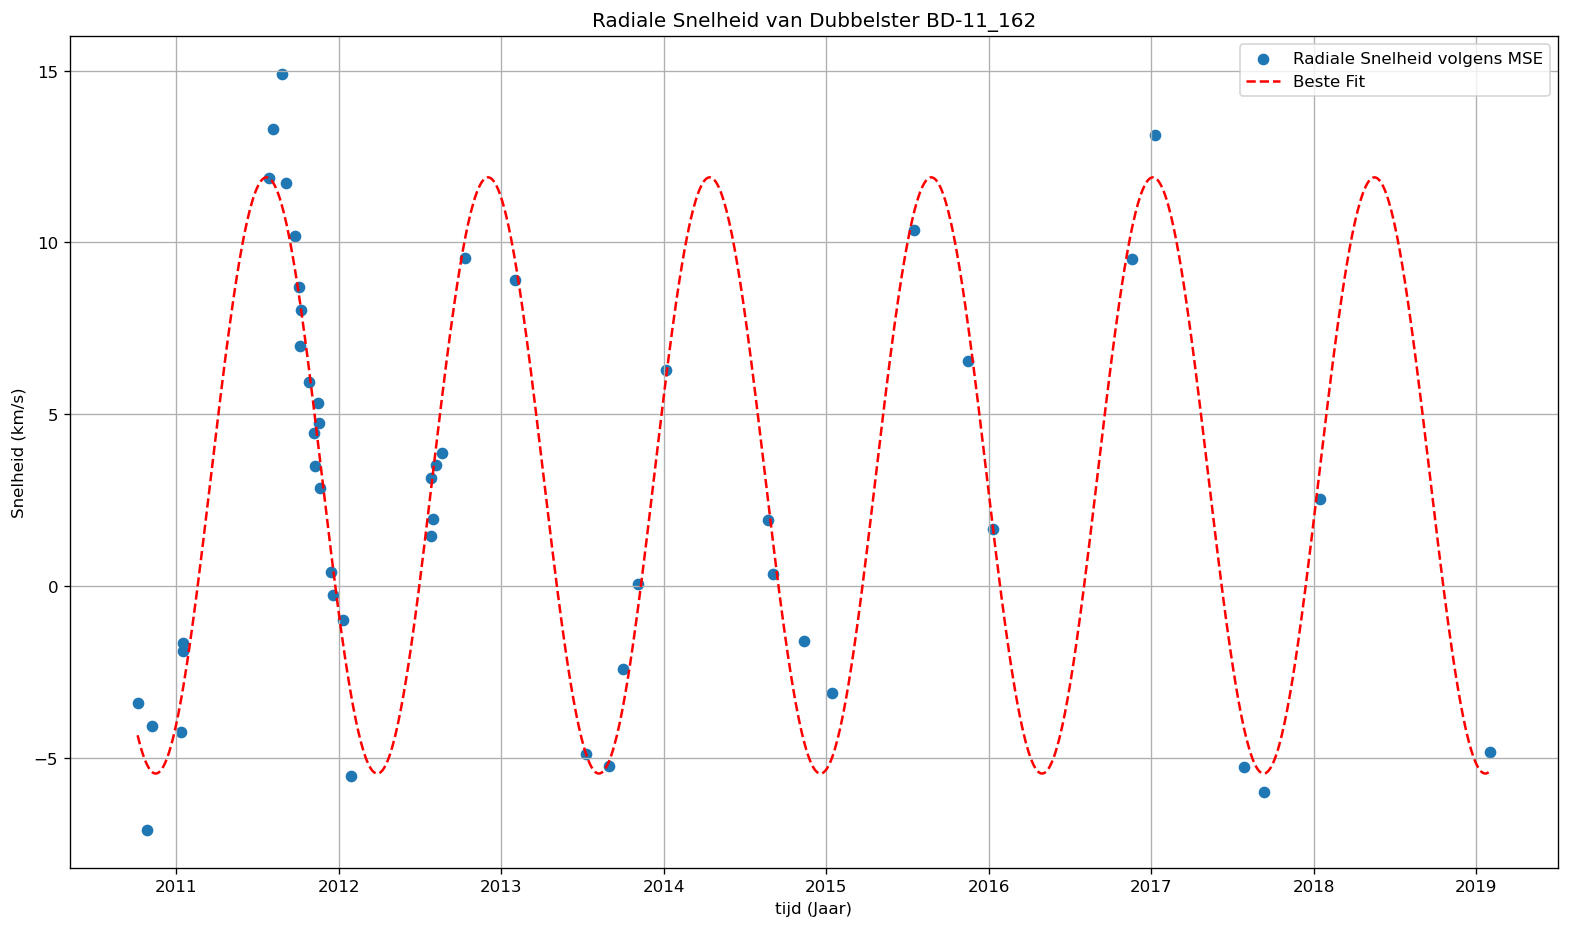

In [490]:
# grafiek 
fig, ax = plt.subplots(dpi=120, figsize=(16, 9))

t_mse = np.linspace(t.min(), t.max(), 1000)
ax.scatter(datum, v, label="Radiale Snelheid volgens MSE")
ax.plot(jul2norm(t_mse),
        radiale_snelheid_fit(t_mse, amplitude, t0, b, P),
        label="Beste Fit",
        color = 'red',
        linestyle='--')

plt.title(f'Radiale Snelheid van Dubbelster {sternaam}')
ax.set_ylabel("Snelheid (km/s)")
ax.set_xlabel("tijd (Jaar)")
plt.legend()
plt.grid(True)
plt.show()

### **Voor Radiale snelheid door fit**

In [491]:
v_fit = fit(tijd, snelheid_fit)
A_fit = v_fit[0][0]
t0_fit = v_fit[0][1]
b_fit = v_fit[0][2]
P_fit = v_fit[0][3]

Amplitude (A): 8.67 +/- 0.28 km/s
t0: 2455640.81 +/- 3.36 dagen
Systemische Snelheid (b): 3.22 +/- 0.19 km/s
Periode (dagen): 498.08 +/- 1.78 dagen


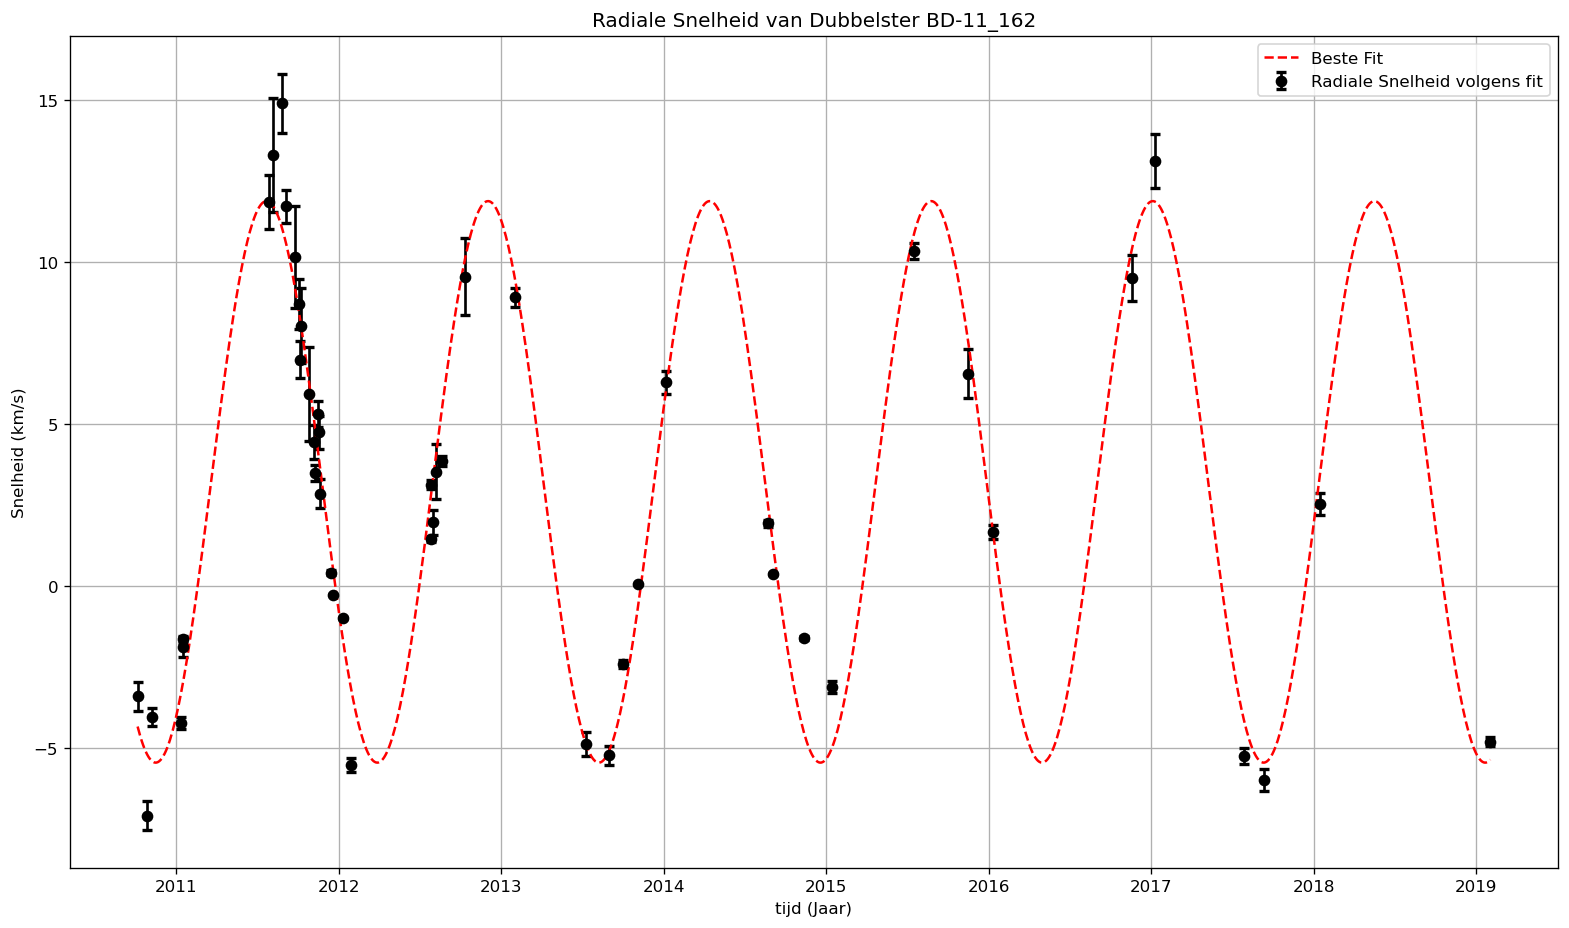

In [492]:
# grafiek 
fig, ax = plt.subplots(dpi=120, figsize=(16, 9))

t_fit = np.linspace(t.min(), t.max(), 1000)
ax.errorbar(
    datum,
    snelheid_fit,
    yerr=onzekerheid_v,
    linestyle='',
    color='black',
    ecolor='black',
    marker="o",
    markersize=6,
    capsize=3,
    capthick=2,
    linewidth=1.6,
    label='Radiale Snelheid volgens fit'
)
ax.plot(jul2norm(t_fit),
        radiale_snelheid_fit(t_fit, A_fit, t0_fit, b_fit, P_fit),
        label="Beste Fit",
        color = 'red',
        linestyle='--')

plt.title(f'Radiale Snelheid van Dubbelster {sternaam}')
ax.set_ylabel("Snelheid (km/s)")
ax.set_xlabel("tijd (Jaar)")
plt.legend()
plt.grid(True)
plt.savefig("Radiale_v.jpg")
plt.show()

# **Massa bepaling**

In [493]:
G = const.G.value
m_zon_kg = const.M_sun.value

# verandering naar SI-eenheden voor berekeningen
m1_kg = 0.6 * m_zon_kg
delta_m1_kg = 0.1*m_zon_kg

def naarSI(P, delta_P, A, delta_A):
    P_sec = P * 60 * 60 *24 # 60s * 60min * 24h = dag
    delta_P_sec = delta_P * 60 * 60 * 24
    A_ms = A * 10**3
    delta_A_ms = delta_A * 10**3
    return P_sec, delta_P_sec, A_ms, delta_A_ms

# functies voor berekeningen
def massa_functie(periode_sec, A_ms, hoek):
    sin_i = np.sin(np.deg2rad(hoek))
    return (periode_sec / (2 * np.pi)) * (A_ms**3 * sin_i)

def onzekerheid_massa_functie(A_ms, sigma_A_ms, P_sec, sigma_P_sec):
    # sigma_f(M)^2 = (v**3/2piG * sigmaP)^2 + (3pi v**2 / 2piG * sigmav)^2
    onzekerheid_f_M = ((A_ms**3 * sigma_P_sec) / (2*np.pi*G))**2 + ((3*P_sec*A_ms**2 *sigma_A_ms) / (2*np.pi*G))**2
    sigma_f_M = np.sqrt(onzekerheid_f_M)
    sigma_f_M_zonnemassa = sigma_f_M / m_zon_kg
    return sigma_f_M, sigma_f_M_zonnemassa


def nulwaarden(a, b, c, d):
    wortels = np.roots([a, b, c, d])
    reele_wortels = wortels[np.isreal(wortels)].real
    return reele_wortels

def massa2(f_M_overG, m1, hoek):
    # f(M)/sin(i)**3 = m2**3 / (m1 + m2)**2
    # neem f(m)/sini**3 als B en m1 als A
    # x**3 - Bx**2 - 2ABx - A**2B ; met x = m2
    sin_i = np.sin(hoek)
    B = f_M_overG / (sin_i**3) # sin_i / sin_i **3 = 1/sin_i**2 
    A = m1
    a = 1.0; b = -B; c = -2*A*B; d = -(A**2) * B
    return nulwaarden(a, b, c, d)

def onzekerheid_m2(m2_kg, m1_kg, inclinatie, sigma_f_M):
    # zet hoek van graden naar radialen
    inclinatie = np.deg2rad(inclinatie)
    sin_i = np.sin(inclinatie)
    
    # we doen partiele afgeleiden van delta_m2/delta_f(m) over f(m) = sin**3 m2**3/(m1+m2)**2
    # voor partiele afgeleide van delta_m2/delta_hoek, delta hoek is ongeveer 0
    # we krijgen dus voor delta_m2/delta_f(m) => 1 = m2' * (sin**3 3*m_2**2 - 2(m1+m2)* sin**3 m2**3)/ (m1+m2)**4
    # we zetten m_2' apart en krijgen we m_2' = (m1+m2)**4 / (3 m2**2 sin**3 - (2(m1+m2) sin**3 m_2**3))
    teller = (m1_kg + m2_kg)**4
    noemer_1 = 3*m2_kg**2*sin_i**3 * (m1_kg + m2_kg)**2
    noemer_2 = 2*(m1_kg + m2_kg) * sin_i**3 * m2_kg**3
    noemer = noemer_1 - noemer_2
    # we nemen geen kwadraat of wortel want we hebben maar 1 onzekerheid nl. f(m)
    
    sigma_m2 = (teller / noemer) * sigma_f_M
    sigma_m2_zonnemassa = sigma_m2 / m_zon_kg

    return abs(sigma_m2), abs(sigma_m2_zonnemassa)

def massa_functie_zonnemassa(P_sec, delta_P_sec, A_ms, delta_A_ms, hoek):
    f_m = massa_functie(P_sec, A_ms, hoek)
    f_m_overG = f_m / G
    f_M_zonnemassa = f_m_overG / m_zon_kg

    # onzekerheid
    delta_f_M_kg, delta_f_M_zonnemassa = onzekerheid_massa_functie(A_ms, delta_A_ms, P_sec, delta_P_sec)
    
    print(f"Massafunctie f(M): {f_M_zonnemassa:.3f} ± {delta_f_M_zonnemassa:.3f} M_zon")
    return f_m_overG, delta_f_M_kg

### **Volgens MSE**

In [494]:
# krijg de gegevens 
delta_A_km = v_mse[1][0]
delta_P_dagen = v_mse[1][3]
# vorm gegevens om naar SI
P_sec, delta_P, A_ms, delta_A = naarSI(P, delta_P_dagen, A, delta_A_km)
# krijg de massa funcite in zonnemassa
f_m_overG_mse, delta_f_M_kg_mse = massa_functie_zonnemassa(P_sec, delta_P, A_ms, delta_A, 90)

# bereken m2 bij i = 90 graden
i_min_rad = np.deg2rad(90)
m2_min_kg_mse = massa2(f_m_overG_mse, m1_kg, i_min_rad)
m2_min_zonnemassa_mse = m2_min_kg_mse / m_zon_kg

# onzekerheid voor minimum massa m2
delta_m2_min_kg_mse, delta_m2_min_zonnemassa_mse = onzekerheid_m2(m2_min_kg_mse, m1_kg, 90, delta_f_M_kg_mse)

print(f"Minimum m_2 (M_zon): {float(m2_min_zonnemassa_mse[0]):.3f} ± {float(delta_m2_min_zonnemassa_mse[0]):.3f} M_zon")

Massafunctie f(M): 0.034 ± 0.003 M_zon
Minimum m_2 (M_zon): 0.301 ± 0.013 M_zon


In [495]:
# Grafiek maken m2 per inclinatie
m2_zonnemassa_lijst_mse = []
delta_m2_zonnemassa_lijst_mse = []
m2_benadering_mse = []
delta_m2_benadering_mse = []

# hoeken generen voor grafiek
inclinatie_graden_benadering = np.linspace(10, 90, 50) # kan niet delen door 0, dus begin altijd > 0
inclinatie_graden = [10, 20, 40, 70, 90]
inclinatie_rad = np.deg2rad(inclinatie_graden)
inclinatie_rad_benadering = np.deg2rad(inclinatie_graden_benadering)

# massa's berekenen
for hoek in inclinatie_rad:
    # bereken massa
    massa2_h = massa2(f_m_overG_mse, m1_kg, hoek)
    m2_zonnemassa_lijst_mse.append(massa2_h / m_zon_kg)
    # bereken onzekerheid
    delta_m2_inc, delta_m2_zonnemassa_inc = onzekerheid_m2(massa2_h, m1_kg, np.rad2deg(hoek), delta_f_M_kg_mse)
    delta_m2_zonnemassa_lijst_mse.append((delta_m2_zonnemassa_inc))

for hoek in inclinatie_rad_benadering:
    massa2_h = massa2(f_m_overG_mse, m1_kg, hoek)
    m2_benadering_mse.append(massa2_h / m_zon_kg)

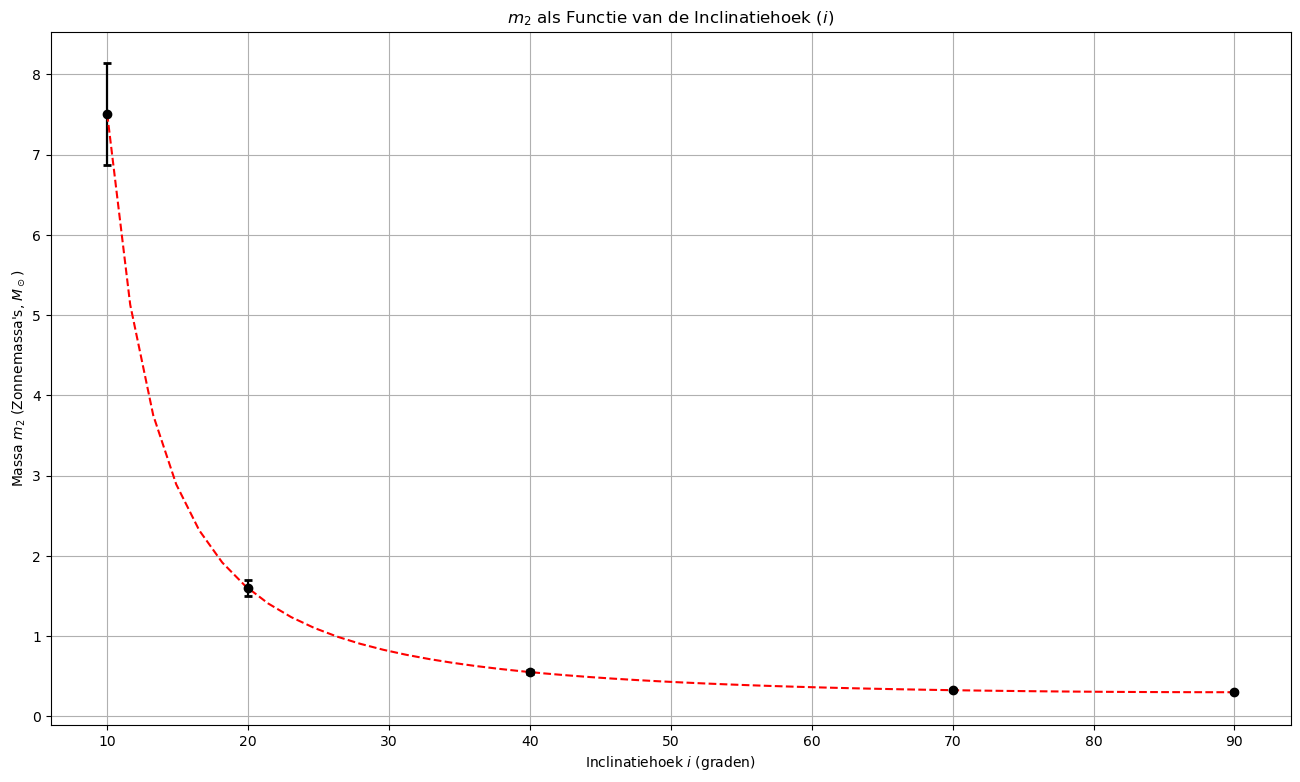

In [496]:
# maak grafiek
fig, ax = plt.subplots(figsize = (16, 9))

# Plot de data met errorbars
ax.errorbar(
    np.array(inclinatie_graden).flatten(),
    np.array(m2_zonnemassa_lijst_mse).flatten(),
    yerr=np.array(delta_m2_zonnemassa_lijst_mse).flatten(),
    linestyle='',
    color='black',
    ecolor='black',
    marker="o",
    markersize=6,
    capsize=3,
    capthick=2,
    linewidth=1.6,
)

# plot stippenlijn door de data
ax.plot(inclinatie_graden_benadering, m2_benadering_mse, color='red', linestyle='--')
plt.title('$m_2$ als Functie van de Inclinatiehoek ($i$)')
ax.set_xlabel('Inclinatiehoek $i$ (graden)')
ax.set_ylabel('Massa $m_2$ (Zonnemassa\'s, $M_\\odot$)')
plt.grid(True)
plt.savefig('m2_functie_hoek.jpg')
plt.show()

### **Volgens Fit**

In [497]:
# krijg de gegevens 
delta_A_km = v_fit[1][0]
delta_P_dagen = v_fit[1][3]
# vorm gegevens om naar SI
P_sec, delta_P, A_ms, delta_A = naarSI(P_fit, delta_P_dagen, A_fit, delta_A_km)
# krijg de massa funcite in zonnemassa
f_m_overG_fit, delta_f_M_kg_fit = massa_functie_zonnemassa(P_sec, delta_P, A_ms, delta_A, 90)

# bereken m2 bij i = 90 graden
i_min_rad = np.deg2rad(75)
m2_min_kg_fit = massa2(f_m_overG_fit, m1_kg, i_min_rad)
m2_min_zonnemassa_fit = m2_min_kg_fit / m_zon_kg

# onzekerheid voor minimum massa m2
delta_m2_min_kg_fit, delta_m2_min_zonnemassa_fit = onzekerheid_m2(m2_min_kg_fit, m1_kg, 75, delta_f_M_kg_fit)

print(f"Minimum m_2 (M_zon): {float(m2_min_zonnemassa_fit[0]):.3f} ± {float(delta_m2_min_zonnemassa_fit[0]):.3f} M_zon")

Massafunctie f(M): 0.034 ± 0.003 M_zon
Minimum m_2 (M_zon): 0.315 ± 0.013 M_zon


**Zoals we kunenn zien, krijgen we exact hetzelfde antwoord voor de massa volgens fit als MSE**

In [499]:
# # maak grafiek
# fig, ax = plt.subplots(figsize = (16, 9))

# # Plot de data met errorbars
# ax.errorbar(
#     np.array(inclinatie_graden).flatten(),
#     np.array(m2_zonnemassa_lijst_mse).flatten(),
#     yerr=np.array(delta_m2_zonnemassa_lijst_mse).flatten(),
#     linestyle='',
#     color='black',
#     ecolor='black',
#     marker="o",
#     markersize=6,
#     capsize=3,
#     capthick=2,
#     linewidth=1.6,
# )

# plt.title('$m_2$ als Functie van de Inclinatiehoek ($i$)')
# ax.set_xlabel('Inclinatiehoek $i$ (graden)')
# ax.set_ylabel('Massa $m_2$ (Zonnemassa\'s, $M_\\odot$)')
# plt.grid(True)
# plt.show()